# Exercises

## Acquire (`acquire.py`)

### Zillow
**For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.**

**You will have a** 
`zillow.ipynb` 
**file and a helper file for each section in the pipeline.**

In [1]:
###############################################################################
### python imports                                                          ###
###############################################################################

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

# from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
###############################################################################
### local imports                                                           ###
###############################################################################

import acquire as acq
import prepare as prep
import clusterfunctions as cf
import explore as xplr

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
from dfo import DFO, set_dfo
from prepare import convert_to_dates, get_column_values_stats, retype_cols, remove_cols, nulls_by_row

In [3]:
local_settings.splain=True
local_settings.debug=True
splain = local_settings.splain
debug = local_settings.debug

In [4]:
from wrangle_zillow import get_zillow_data, get_zillow_local_data, prep_zillow_data, sqls, keep_cols

#### Acquire & Summarize

1. **Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.**

   - *Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for* 
`airconditioningtypeid`
*.*
   - Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
   - Only include properties that include a latitude and longitude value.

In [5]:
# dfo = set_dfo(get_zillow_data(sql=sqls['mvp']), splain=True)
dfo = set_dfo(get_zillow_local_data(csv='zillow_local_mvp.csv'), splain=True)

2019-11-11 16:56:36 starting get_zillow_local_data
2019-11-11 16:56:36 starting csv_df
2019-11-11 16:56:37 starting check_df
2019-11-11 16:56:37 starting frame_splain
DATAFRAME SHAPE:
(52089, 11) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52089 entries, 0 to 52088
Data columns (total 11 columns):
id                              52089 non-null int64
parcelid                        52089 non-null int64
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
fips                            52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(9), int64(2)
memory usage: 4.4 MB
None 

DATAFRAME DESCRIPTI

2. **Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.).**

In [6]:
df = dfo.df

In [7]:
df = remove_cols(df, ['Unnamed: 0', 'id'])

2019-11-11 16:56:37 starting remove_cols
2019-11-11 16:56:37 ending remove_cols ; time: 0:00:00.003048


In [8]:
dfo.index_columns = 'parcelid'

In [9]:
df = df.set_index(dfo.index_columns)

In [10]:
dfo.y_column = 'logerror'

In [11]:
dfo.stratify = 'fips'

In [12]:
frame_splain(df, title='Zillow Data', splain=True)

2019-11-11 16:56:37 starting frame_splain
ZILLOW DATA SHAPE:
(52089, 9) 

ZILLOW DATA INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 9 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
fips                            52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(9)
memory usage: 4.0 MB
None 

ZILLOW DATA DESCRIPTION:
                                count          mean            std  \
bathroomcnt                   52089.0  2.305669e+00       1.017265   
bedroomcnt                    52089.0  3.309912e+00       0.933453   
calculatedfin

In [13]:
date_columns = ['transactiondate']
df = convert_to_dates(df, cols=date_columns)

2019-11-11 16:56:37 starting convert_to_dates
2019-11-11 16:56:37 ending convert_to_dates ; time: 0:00:00.002487


In [14]:
df.head(15)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,structuretaxvaluedollarcnt,structuredollarpersqft,logerror
parcelid,,,,,,,,,
14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,485713.0,156.681613,0.025595
17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,88000.0,60.068259,0.055619
14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,85289.0,68.615447,0.005383
12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,108918.0,45.840909,-0.103410
12095076,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,276684.0,93.411209,-0.001011
12069064,1.0,2.0,738.0,6037.0,34149214.0,-118239357.0,18890.0,25.596206,0.101723
12790562,3.0,4.0,3039.0,6037.0,33960230.0,-118006914.0,177527.0,58.416255,-0.040966
11104527,3.0,4.0,2540.0,6037.0,34434971.0,-118464390.0,271715.0,106.974409,0.005963
13944538,2.5,3.0,1340.0,6059.0,33771438.0,-117982834.0,96617.0,72.102239,0.045602


In [15]:
frame_splain(df, splain=True)

2019-11-11 16:56:37 starting frame_splain
DATAFRAME SHAPE:
(52089, 9) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 9 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
fips                            52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(9)
memory usage: 4.0 MB
None 

DATAFRAME DESCRIPTION:
                                count          mean            std  \
bathroomcnt                   52089.0  2.305669e+00       1.017265   
bedroomcnt                    52089.0  3.309912e+00       0.933453   
calculatedfinisheds

**Find string categoricals**

In [16]:
df_strings = get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes=='object'],
    max_uniques=20000,
    limit_to_max=True
)
df_strings

2019-11-11 16:56:37 starting get_column_values_stats
2019-11-11 16:56:37 ending get_column_values_stats ; time: 0:00:00.163485


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52089,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52089,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52089,0,0.0,4710,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."
fips,float64,52089,0,0.0,3,"[6059.0, 6111.0, 6037.0]"


In [17]:
df_strings.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips'], dtype='object', name='cols')

In [18]:
string_categoricals = [
    'airconditioningdesc', 
    'architecturalstyledesc', 
    'buildingclassdesc', 
    'county', 
    'state', 
    'heatingorsystemdesc', 
    'propertycountylandusecode', 
    'propertylandusedesc', 
    'propertyzoningdesc', 
    'storydesc', 
    'taxdelinquencyflag', 
    'typeconstructiondesc'
]

In [19]:
df = retype_cols(df, cols=string_categoricals, to_dtype='category')
df.info()

2019-11-11 16:56:37 starting retype_cols
2019-11-11 16:56:37 ending retype_cols ; time: 0:00:00.002612
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 9 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
fips                            52089 non-null float64
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: float64(9)
memory usage: 4.0 MB


**Find Numeric Categoricals**

In [20]:
df_cat_check = prep.get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes!='category'],
    max_uniques=750000,
    target_col=dfo.y_column,
    limit_to_max=True
)
df_cat_check

2019-11-11 16:56:37 starting get_column_values_stats
2019-11-11 16:56:38 ending get_column_values_stats ; time: 0:00:00.160252


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52089,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52089,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52089,0,0.0,4710,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."
fips,float64,52089,0,0.0,3,"[6059.0, 6111.0, 6037.0]"
latitude,float64,52089,0,0.0,50293,"[33634931.0, 34449266.0, 33886168.0, 34245180...."
longitude,float64,52089,0,0.0,50571,"[-117869207.0, -119281531.0, -117823170.0, -11..."
structuretaxvaluedollarcnt,float64,52089,0,0.0,37220,"[485713.0, 88000.0, 85289.0, 108918.0, 276684...."
structuredollarpersqft,float64,52089,0,0.0,51809,"[156.6816129032258, 60.068259385665534, 68.615..."


In [21]:
df_cat_check.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips',
       'latitude', 'longitude', 'structuretaxvaluedollarcnt',
       'structuredollarpersqft'],
      dtype='object', name='cols')

In [22]:
numeric_categoricals = [
    'airconditioningtypeid', 
    'architecturalstyletypeid', 
    'buildingclasstypeid', 
    'buildingqualitytypeid',
    'decktypeid', 
    'fips', 
    'hashottuborspa',
    'heatingorsystemtypeid',
    'pooltypeid10', 
    'pooltypeid2', 
    'pooltypeid7', 
    'propertylandusetypeid',
    'regionidcounty', 
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'rawcensustractandblock',
    'censustractandblock',
    'storytypeid', 
    'threequarterbathnbr', 
    'numberofstories', 
    'fireplaceflag', 
    'assessmentyear', 
    'typeconstructiontypeid', 
    'transactions'
]

In [23]:
df = retype_cols(df, cols=numeric_categoricals, to_dtype='category')
df.info()

2019-11-11 16:56:38 starting retype_cols
2019-11-11 16:56:38 ending retype_cols ; time: 0:00:00.006319
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52089 entries, 14297519 to 12826780
Data columns (total 9 columns):
bathroomcnt                     52089 non-null float64
bedroomcnt                      52089 non-null float64
calculatedfinishedsquarefeet    52089 non-null float64
fips                            52089 non-null category
latitude                        52089 non-null float64
longitude                       52089 non-null float64
structuretaxvaluedollarcnt      52089 non-null float64
structuredollarpersqft          52089 non-null float64
logerror                        52089 non-null float64
dtypes: category(1), float64(8)
memory usage: 3.6 MB


In [24]:
nulls_by_row(df)

2019-11-11 16:56:38 starting nulls_by_row
2019-11-11 16:56:38 ending nulls_by_row ; time: 0:00:00.106447


,num_cols_missing,pct_cols_missing,parcelid
0,0,0.0,52089


In [25]:
dfo.df = df

Split to Train and Test

In [26]:
dfo = prep.split_dfo(dfo, train_pct=.7, randomer=12345, stratify=dfo.stratify, drop_cols={'id'}, splain=local_settings.splain)

2019-11-11 16:56:38 starting split_dfo
2019-11-11 16:56:38 starting remove_cols
2019-11-11 16:56:38 ending remove_cols ; time: 0:00:00.000124
2019-11-11 16:56:38 starting split_my_data_whole
2019-11-11 16:56:38 ending split_my_data_whole ; time: 0:00:00.009444
2019-11-11 16:56:38 starting frame_splain
DFO TRAIN SHAPE:
(39066, 9) 

DFO TRAIN INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 9 columns):
bathroomcnt                     39066 non-null float64
bedroomcnt                      39066 non-null float64
calculatedfinishedsquarefeet    39066 non-null float64
fips                            39066 non-null category
latitude                        39066 non-null float64
longitude                       39066 non-null float64
structuretaxvaluedollarcnt      39066 non-null float64
structuredollarpersqft          39066 non-null float64
logerror                        39066 non-null float64
dtypes: category(1), float64(8)
memor

In [27]:
dfo.train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 9 columns):
bathroomcnt                     39066 non-null float64
bedroomcnt                      39066 non-null float64
calculatedfinishedsquarefeet    39066 non-null float64
fips                            39066 non-null category
latitude                        39066 non-null float64
longitude                       39066 non-null float64
structuretaxvaluedollarcnt      39066 non-null float64
structuredollarpersqft          39066 non-null float64
logerror                        39066 non-null float64
dtypes: category(1), float64(8)
memory usage: 2.7 MB


In [28]:
dfo.train = remove_cols(dfo.train, [dfo.stratify])

2019-11-11 16:56:38 starting remove_cols
2019-11-11 16:56:38 ending remove_cols ; time: 0:00:00.001806


In [29]:
dfo.test = remove_cols(dfo.test, [dfo.stratify])

2019-11-11 16:56:38 starting remove_cols
2019-11-11 16:56:38 ending remove_cols ; time: 0:00:00.002465


In [30]:
train = dfo.train
test = dfo.test

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 8 columns):
bathroomcnt                     39066 non-null float64
bedroomcnt                      39066 non-null float64
calculatedfinishedsquarefeet    39066 non-null float64
latitude                        39066 non-null float64
longitude                       39066 non-null float64
structuretaxvaluedollarcnt      39066 non-null float64
structuredollarpersqft          39066 non-null float64
logerror                        39066 non-null float64
dtypes: float64(8)
memory usage: 2.7 MB


In [32]:
#dfo.df = df
#dfo.df.info()

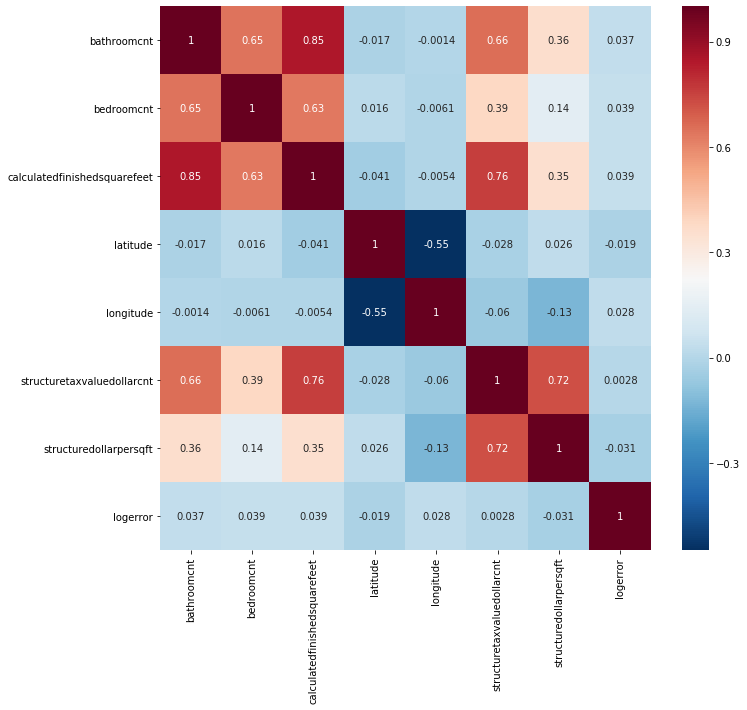

In [33]:
plt.figure(figsize=(11,10))
cor = train.corr()
plot = sns.heatmap(cor, annot=True, cmap=plt.cm.RdBu_r)


In [34]:
cor

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,structuretaxvaluedollarcnt,structuredollarpersqft,logerror
bathroomcnt,1.000000,0.645794,0.852687,-0.017166,-0.001405,0.656875,0.364529,0.036843
bedroomcnt,0.645794,1.000000,0.632841,0.016069,-0.006119,0.387774,0.144502,0.038970
calculatedfinishedsquarefeet,0.852687,0.632841,1.000000,-0.040820,-0.005383,0.758492,0.353004,0.039157
latitude,-0.017166,0.016069,-0.040820,1.000000,-0.548024,-0.027778,0.026482,-0.018752
longitude,-0.001405,-0.006119,-0.005383,-0.548024,1.000000,-0.059750,-0.126626,0.027743
structuretaxvaluedollarcnt,0.656875,0.387774,0.758492,-0.027778,-0.059750,1.000000,0.723575,0.002756
structuredollarpersqft,0.364529,0.144502,0.353004,0.026482,-0.126626,0.723575,1.000000,-0.030751
logerror,0.036843,0.038970,0.039157,-0.018752,0.027743,0.002756,-0.030751,1.000000


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 8 columns):
bathroomcnt                     39066 non-null float64
bedroomcnt                      39066 non-null float64
calculatedfinishedsquarefeet    39066 non-null float64
latitude                        39066 non-null float64
longitude                       39066 non-null float64
structuretaxvaluedollarcnt      39066 non-null float64
structuredollarpersqft          39066 non-null float64
logerror                        39066 non-null float64
dtypes: float64(8)
memory usage: 2.7 MB


In [36]:
# sns.pairplot(df)

In [37]:
dfo.X_train, dfo.y_train = prep.xy_df(dfo.train, dfo.y_column)

2019-11-11 16:56:39 starting xy_df
2019-11-11 16:56:39 starting frame_splain
2019-11-11 16:56:39 ending frame_splain ; time: 0:00:00.000195
2019-11-11 16:56:39 starting frame_splain
2019-11-11 16:56:39 ending frame_splain ; time: 0:00:00.000128
2019-11-11 16:56:39 ending xy_df ; time: 0:00:00.005972


In [38]:
X = dfo.X_train
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 7 columns):
bathroomcnt                     39066 non-null float64
bedroomcnt                      39066 non-null float64
calculatedfinishedsquarefeet    39066 non-null float64
latitude                        39066 non-null float64
longitude                       39066 non-null float64
structuretaxvaluedollarcnt      39066 non-null float64
structuredollarpersqft          39066 non-null float64
dtypes: float64(7)
memory usage: 2.4 MB


In [39]:
y = dfo.y_train

In [40]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 1 columns):
logerror    39066 non-null float64
dtypes: float64(1)
memory usage: 610.4 KB


In [41]:
y.head()

,logerror
parcelid,
12709284,0.154148
17135073,-0.003112
11450752,0.149855
12887447,0.003864
10935173,0.074136


In [42]:
dfo.X_test, dfo.y_test = prep.xy_df(dfo.test, dfo.y_column)

2019-11-11 16:56:39 starting xy_df
2019-11-11 16:56:39 starting frame_splain
2019-11-11 16:56:39 ending frame_splain ; time: 0:00:00.000742
2019-11-11 16:56:39 starting frame_splain
2019-11-11 16:56:39 ending frame_splain ; time: 0:00:00.000676
2019-11-11 16:56:39 ending xy_df ; time: 0:00:00.007025


In [43]:
X_test = dfo.X_test

In [44]:
y_test = dfo.y_test

In [45]:
cluster_cols = ['longitude', 'latitude', 'structuredollarpersqft']

In [46]:
cluster_col = ['cluster']

In [47]:
ignore_cols = ['structuretaxvaluedollarcnt']

In [48]:
non_cluster_cols = [col for col in X.columns if col not in cluster_cols + ignore_cols + cluster_col]

In [49]:
non_cluster_cols

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']

In [50]:
Xc = X[cluster_cols]

In [51]:
Xc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 3 columns):
longitude                 39066 non-null float64
latitude                  39066 non-null float64
structuredollarpersqft    39066 non-null float64
dtypes: float64(3)
memory usage: 1.2 MB


In [52]:
Xc.head()

,longitude,latitude,structuredollarpersqft
parcelid,,,
12709284,-118409671.0,33761779.0,42.654506
17135073,-119053514.0,34230054.0,96.890456
11450752,-118318877.0,33876320.0,30.579299
12887447,-117765318.0,34055348.0,60.645161
10935173,-118347902.0,34127486.0,291.296841


In [53]:
Xnc = X[non_cluster_cols]
Xnc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 3 columns):
bathroomcnt                     39066 non-null float64
bedroomcnt                      39066 non-null float64
calculatedfinishedsquarefeet    39066 non-null float64
dtypes: float64(3)
memory usage: 1.2 MB


In [54]:
Xnc.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
parcelid,,,
12709284,2.0,3.0,1864.0
17135073,2.0,4.0,1844.0
11450752,2.0,3.0,1198.0
12887447,1.0,2.0,775.0
10935173,4.0,3.0,2722.0


In [55]:
Xc_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(Xc)

In [56]:
Xc_scaled = pd.DataFrame(Xc_scaler.transform(Xc), columns=Xc.columns.values).set_index([Xc.index.values])

In [57]:
Xc_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 3 columns):
longitude                 39066 non-null float64
latitude                  39066 non-null float64
structuredollarpersqft    39066 non-null float64
dtypes: float64(3)
memory usage: 1.2 MB


In [58]:
Xc_scaled['sdpsf_score'] = Xc_scaled.structuredollarpersqft * 15

In [59]:
Xc_structuredollarpersqft = Xc_scaled[['structuredollarpersqft']]
Xc_scaled = Xc_scaled.drop(columns='structuredollarpersqft')

In [60]:
# cf.compare_ks(Xc_scaled, min_k=4, max_k=18)

In [61]:
Xc_scaled, Xc_kmeans = cf.set_kmeans_clusters(Xc_scaled, n_clusters=8, random_state=dfo.randomer)
Xc_scaled.head(15)

2019-11-11 16:56:40 starting set_kmeans_clusters
2019-11-11 16:56:42 ending set_kmeans_clusters ; time: 0:00:02.578989


,longitude,latitude,sdpsf_score,cluster
12709284,0.554850,0.284924,0.442618,3
17135073,0.219651,0.601722,1.005940,7
11450752,0.602119,0.362413,0.317198,3
12887447,0.890314,0.483530,0.629478,0
10935173,0.587008,0.532333,3.025143,2
12173882,0.716412,0.561346,0.915112,7
12723102,0.715062,0.396322,0.785834,0
12241721,0.617050,0.397116,0.221414,3
11111466,0.487865,0.749444,1.199100,6
14296641,0.832970,0.192293,0.445037,3


In [62]:
@timeifdebug
def features_2d(df, c_col=None, **kwargs):
    
    cols = [col for col in df.columns if col != c_col]
    n = len(cols)
    grid = []
    for x in range(0, n-1):
        for y in range(x+1, n):
            line = [cols[x], cols[y]]
            grid.append(line)
    
    return_df = pd.DataFrame(grid, columns=['x_col', 'y_col'])
    if c_col:
        return_df['c_col'] = c_col
    return return_df



In [63]:
@timeifdebug
def features_3d(df, c_col=None, **kwargs):
    
    cols = [col for col in df.columns if col != c_col]
    n = len(cols)
    grid = []
    for x in range(0, n-2):
        for y in range(x+1, n-1):
            for z in range(y+1, n):
                line = [cols[x], cols[y], cols[z]]
                grid.append(line)
    

    return_df = pd.DataFrame(grid, columns=['x_col', 'y_col', 'z_col'])
    if c_col:
        return_df['c_col'] = c_col
    return return_df



In [64]:
# features_2d(Xc_scaled)

In [65]:
features_cl = features_2d(Xc_scaled, c_col=cluster_col[0])
features_cl

2019-11-11 16:56:42 starting features_2d
2019-11-11 16:56:42 ending features_2d ; time: 0:00:00.006936


,x_col,y_col,c_col
0,longitude,latitude,cluster
1,longitude,sdpsf_score,cluster
2,latitude,sdpsf_score,cluster


In [66]:
# features_3d(Xc_scaled, c_col=)

In [67]:
# features_3d(X)

In [68]:
@timeifdebug
def plot_features_2D(feature_df, df, x_col='x_col', y_col='y_col', c_col='c_col'):
    x_vals = feature_df[x_col]
    y_vals = feature_df[y_col]
    c_vals = feature_df[c_col]
    n = len(x_vals)
    for idx in range(0,n):
        plt.figure(figsize=(8,7))
        cf.plot_2d_clusters(
            df, 
            x_col=x_vals[idx], 
            y_col=y_vals[idx], 
            c_col=c_vals[idx], 
            alpha=.5, 
#             marker='x', 
#             s=250, 
#             c='black'
        )
        plt.show()

2019-11-11 16:56:42 starting plot_features_2D
2019-11-11 16:56:42 starting plot_2d_clusters
2019-11-11 16:56:43 ending plot_2d_clusters ; time: 0:00:01.013589


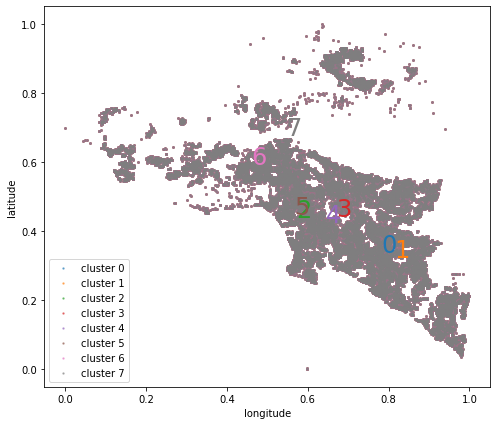

2019-11-11 16:56:51 starting plot_2d_clusters
2019-11-11 16:56:51 ending plot_2d_clusters ; time: 0:00:00.710486


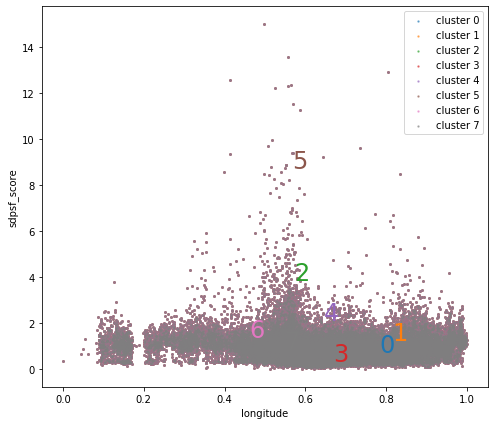

2019-11-11 16:56:57 starting plot_2d_clusters
2019-11-11 16:56:58 ending plot_2d_clusters ; time: 0:00:00.697717


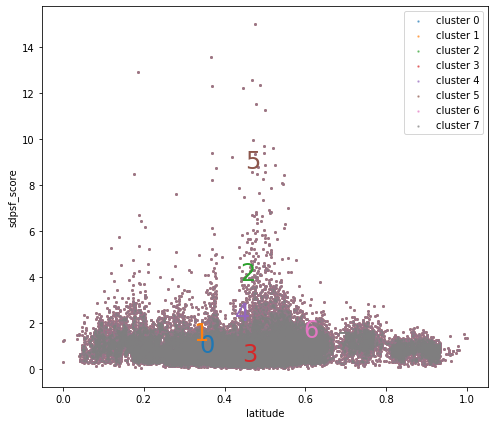

2019-11-11 16:57:03 ending plot_features_2D ; time: 0:00:20.934405


In [69]:
plot_features_2D(features_cl, Xc_scaled)

In [71]:
cluster_y = prep.df_join_xy(Xc_scaled[[cluster_col[0]]], y) 

2019-11-11 16:57:33 starting df_join_xy
2019-11-11 16:57:33 starting frame_splain
2019-11-11 16:57:33 ending frame_splain ; time: 0:00:00.000311
2019-11-11 16:57:33 ending df_join_xy ; time: 0:00:00.011523


In [72]:
frame_splain(cluster_y, splain=True)

2019-11-11 16:57:35 starting frame_splain
DATAFRAME SHAPE:
(39066, 2) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39066 entries, 12709284 to 11344051
Data columns (total 2 columns):
cluster     39066 non-null int32
logerror    39066 non-null float64
dtypes: float64(1), int32(1)
memory usage: 2.0 MB
None 

DATAFRAME DESCRIPTION:
            count      mean       std      min       25%       50%       75%  \
cluster   39066.0  3.117903  2.652862  0.00000  0.000000  3.000000  6.000000   
logerror  39066.0  0.017724  0.177520 -4.65542 -0.024943  0.006854  0.040359   

               max  
cluster   7.000000  
logerror  5.262999   

DATAFRAME HEAD:
          cluster  logerror
12709284        3  0.154148
17135073        7 -0.003112
11450752        3  0.149855
12887447        0  0.003864
10935173        2  0.074136 

2019-11-11 16:57:35 ending frame_splain ; time: 0:00:00.030896


In [73]:
c_col = cluster_col[0]
y_col = dfo.y_column
# cluster_stats = (pd.DataFrame(Xc_scaled[c_col].value_counts()) #, columns=['count']
#     .reset_index()
#     .rename(columns={'index': c_col, c_col: c_col + '_count'})
#     .sort_values(by=c_col)
#     #.set_index(cluster_col[0])
#                 )

# cluster_stats['index'] = cluster_stats[c_col]
# cluster_stats = cluster_stats.set_index('index')

In [88]:
XncC = prep.df_join_xy(Xnc, Xc_scaled['cluster']) 
XncC.head()

2019-11-11 16:59:59 starting df_join_xy
2019-11-11 16:59:59 starting frame_splain
2019-11-11 16:59:59 ending frame_splain ; time: 0:00:00.000145
2019-11-11 16:59:59 ending df_join_xy ; time: 0:00:00.006342


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster
parcelid,,,,
12709284,2.0,3.0,1864.0,3
17135073,2.0,4.0,1844.0,7
11450752,2.0,3.0,1198.0,3
12887447,1.0,2.0,775.0,0
10935173,4.0,3.0,2722.0,2


In [89]:
# cluster_stats[y_col + '_mean'] = cluster_stats[c_col].apply(lambda x: cluster_y[cluster_y[c_col] == x][y_col].mean())

In [90]:
# cluster_stats[y_col + '_std'] = cluster_stats[c_col].apply(lambda x: cluster_y[cluster_y[c_col] == x][y_col].std())

In [91]:
# Xc_scaled.assign(logerror=cluster_y)
cluster_stats = cluster_y.groupby('cluster').logerror.agg(['count', 'mean', 'std']).reset_index()

In [92]:
cluster_stats

,cluster,count,mean,std
0,0,9903,0.020616,0.168071
1,1,5729,0.017810,0.187241
2,2,358,0.009353,0.233194
3,3,8667,0.025534,0.201871
4,4,2160,0.011250,0.188869
5,5,50,-0.077525,0.365626
6,6,4925,0.008740,0.150717
7,7,7274,0.013484,0.157689


In [93]:
for c in cluster_stats.cluster:
    subset=cluster_y[cluster_y.cluster == c]
    
    

In [94]:
# cluster_stats.columns=cluster_stats.columns.to_flat_index()

In [95]:
df_stats = y.agg(['count', 'mean', 'std'])
df_stats

,logerror
count,39066.000000
mean,0.017724
std,0.177520


In [96]:
from math import sqrt
from scipy import stats


@timeifdebug
def bool_ttest_single_uniq(df, target_column='target', check_column='check', alpha=.05, **kwargs):

    p_list = []
    uniq_vals = sorted(df[check_column].unique())
    print(uniq_vals)
    #tgt_name = target_column
    #chk_name = check_column
    for val in uniq_vals:
        is_true = df[df[check_column] == val]
        num_true = len(is_true)
        y_if_true = is_true[target_column].mean()
        std_if_true = is_true[target_column].std()
        y_mean = df[target_column].mean()
        y_std = df[target_column].std()
        t, p = stats.ttest_1samp(is_true[target_column], df[target_column].mean())
        p_list.append([check_column, val, num_true, t, p, p<alpha, y_if_true, y_mean, std_if_true, y_std])
    df_p = (pd.DataFrame(
        p_list, 
        columns=[
            'column','value','count','t_stat','p_value','is_sig',
            target_column+'_if_value',target_column+'_mean',
            'std_if_value','std_all'])
        .set_index(['value'])
            .sort_values(by='p_value'))
    return df_p


In [97]:
bool_ttest_single_uniq(cluster_y, target_column=dfo.y_column, check_column='cluster', alpha=.05, debug=True)

2019-11-11 17:00:09 starting bool_ttest_single_uniq
[0, 1, 2, 3, 4, 5, 6, 7]
2019-11-11 17:00:09 ending bool_ttest_single_uniq ; time: 0:00:00.023721


,column,count,t_stat,p_value,is_sig,logerror_if_value,logerror_mean,std_if_value,std_all
value,,,,,,,,,
6,cluster,4925,-4.183089,0.000029,True,0.008740,0.017724,0.150717,0.17752
3,cluster,8667,3.601901,0.000318,True,0.025534,0.017724,0.201871,0.17752
7,cluster,7274,-2.293179,0.021866,True,0.013484,0.017724,0.157689,0.17752
5,cluster,50,-1.842076,0.071520,False,-0.077525,0.017724,0.365626,0.17752
0,cluster,9903,1.712514,0.086833,False,0.020616,0.017724,0.168071,0.17752
4,cluster,2160,-1.593032,0.111299,False,0.011250,0.017724,0.188869,0.17752
2,cluster,358,-0.679250,0.497420,False,0.009353,0.017724,0.233194,0.17752
1,cluster,5729,0.034836,0.972212,False,0.017810,0.017724,0.187241,0.17752


In [98]:
XncC['c6'] = XncC.cluster == 6
XncC['c3'] = XncC.cluster == 3
XncC['c7'] = XncC.cluster == 7
# XncC['c0'] = XncC.cluster == 0
XncCs = XncC.drop(columns='cluster')
XncCs.head(15)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,c6,c3,c7
parcelid,,,,,,
12709284,2.0,3.0,1864.0,False,True,False
17135073,2.0,4.0,1844.0,False,False,True
11450752,2.0,3.0,1198.0,False,True,False
12887447,1.0,2.0,775.0,False,False,False
10935173,4.0,3.0,2722.0,False,False,False
12173882,1.0,2.0,1586.0,False,False,True
12723102,3.0,4.0,1877.0,False,False,False
12241721,1.0,2.0,1114.0,False,True,False
11111466,2.0,4.0,1624.0,True,False,False


In [113]:
import evaluate as p_eval

In [133]:
y_bl = pd.DataFrame(y)
y_bl = remove_cols(p_eval.make_baseline(y_bl, x_cols=list(y_bl.columns), y_col=dfo.y_column), [dfo.y_column])
y_bl.head()

2019-11-11 17:16:58 starting remove_cols
2019-11-11 17:16:58 ending remove_cols ; time: 0:00:00.002861


,y,yhat,residual,residual^2
parcelid,,,,
12709284,0.154148,0.017724,-0.136424,0.018612
17135073,-0.003112,0.017724,0.020837,0.000434
11450752,0.149855,0.017724,-0.132131,0.017459
12887447,0.003864,0.017724,0.013861,0.000192
10935173,0.074136,0.017724,-0.056411,0.003182


In [99]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']


In [100]:
# print(colors)

In [101]:
# lwbase = plt.rcParams['lines.linewidth']
# thin = lwbase / 2
# thick = lwbase * 3

# fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
# for icol in range(2):
#     if icol == 0:
#         lwx, lwy = thin, lwbase
#     else:
#         lwx, lwy = lwbase, thick
#     for irow in range(2):
#         for i, color in enumerate(colors):
#             axs[irow, icol].axhline(i, color=color, lw=lwx)
#             axs[irow, icol].axvline(i, color=color, lw=lwy)

#     axs[1, icol].set_facecolor('k')
#     axs[1, icol].xaxis.set_ticks(np.arange(0, 10, 2))
#     axs[0, icol].set_title('line widths (pts): %g, %g' % (lwx, lwy),
#                            fontsize='medium')

# for irow in range(2):
#     axs[irow, 0].yaxis.set_ticks(np.arange(0, 10, 2))

# fig.suptitle('Colors in the default prop_cycle', fontsize='large')

# plt.show()

In [ ]:
# sns.palplot(sns.color_palette('muted', n_colors=10, desat=1))

In [ ]:
# sns_colors=sns.color_palette()
# sns_colors.as_hex()

In [ ]:
# sns_colors2=sns.color_palette('muted', n_colors=10, desat=.75)
# sns_colors2.as_hex()

In [102]:
from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

In [103]:
if 'prediction' in XncCs.columns:
    XncCs = XncCs.drop(columns='prediction')

In [214]:
dtr = DecisionTreeRegressor(
    max_depth=9,
    random_state=dfo.randomer,
    min_samples_leaf=3,
    max_leaf_nodes=None
)
dtr.fit(XncCs, y)
#clf = clf.fit(XncCs, dfo.y_column)

import graphviz

from graphviz import Graph

#dot_data = export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 

#graph.render('iris_decision_tree', view=True)

In [215]:
# cross_val_score(dtr, XncCs, y, cv=10)


In [216]:
dtr_score_ = dtr.score(XncCs, y)
dtr_score_

0.0423786583786

In [217]:
dtr_pred_ = dtr.predict(XncCs)

In [218]:
Xp = XncCs[XncCs.columns]

In [219]:
Xp = Xp.join(y_bl[['y', 'yhat']])
Xp

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,c6,c3,c7,y,yhat
parcelid,,,,,,,,
12709284,2.0,3.0,1864.0,False,True,False,0.154148,0.017724
17135073,2.0,4.0,1844.0,False,False,True,-0.003112,0.017724
11450752,2.0,3.0,1198.0,False,True,False,0.149855,0.017724
12887447,1.0,2.0,775.0,False,False,False,0.003864,0.017724
10935173,4.0,3.0,2722.0,False,False,False,0.074136,0.017724
12173882,1.0,2.0,1586.0,False,False,True,0.058269,0.017724
12723102,3.0,4.0,1877.0,False,False,False,0.043600,0.017724
12241721,1.0,2.0,1114.0,False,True,False,0.020307,0.017724
11111466,2.0,4.0,1624.0,True,False,False,0.038924,0.017724


In [220]:
Xp['pred_dtr'] = dtr_pred_
Xp

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,c6,c3,c7,y,yhat,pred_dtr
parcelid,,,,,,,,,
12709284,2.0,3.0,1864.0,False,True,False,0.154148,0.017724,0.023560
17135073,2.0,4.0,1844.0,False,False,True,-0.003112,0.017724,0.007364
11450752,2.0,3.0,1198.0,False,True,False,0.149855,0.017724,0.008372
12887447,1.0,2.0,775.0,False,False,False,0.003864,0.017724,0.006472
10935173,4.0,3.0,2722.0,False,False,False,0.074136,0.017724,0.011454
12173882,1.0,2.0,1586.0,False,False,True,0.058269,0.017724,0.006472
12723102,3.0,4.0,1877.0,False,False,False,0.043600,0.017724,0.023760
12241721,1.0,2.0,1114.0,False,True,False,0.020307,0.017724,-0.023854
11111466,2.0,4.0,1624.0,True,False,False,0.038924,0.017724,-0.000663


In [221]:
dtr.get_params()

{'criterion': 'mse',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 12345,
 'splitter': 'best'}

In [222]:
bl_errors = p_eval.regression_errors(Xp.y, Xp.yhat)
print(bl_errors)
dtr_errors = p_eval.regression_errors(Xp.y, Xp.pred_dtr)
print(dtr_errors)


{'ESS': 0.0, 'MSE': 0.03151261612727865, 'SSE': 1231.071861628268, 'TSS': 1231.071861628268, 'RMSE': 0.17751793184711975}
{'ESS': 52.171173863447464, 'MSE': 0.03017715373380475, 'SSE': 1178.9006877648164, 'TSS': 1231.0718616282638, 'RMSE': 0.1737157267889259}


In [223]:
y.std()

logerror    0.17752
dtype: float64

In [224]:
bl_errors['RMSE']/y.std()

logerror    0.999987
dtype: float64

In [225]:
dtr_errors['RMSE']/y.std()

logerror    0.978569
dtype: float64